# Expansión de consultas usando word embeddings

## Setup
Antes de ejecutar este notebook asegurate de que elasticsearch está iniciado. Además los tweets deben estar indexados. Para indexarlos ejecuta el script 'index.py'. 

## Importando las librerías
Lo primero que vamos a hacer será importar las librerías que se usarán a lo largo de este trabajo:

In [92]:
import re
import string

import elasticsearch.helpers
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search, Q
from gensim.models import word2vec
from glove import Glove
from glove import Corpus
from memory_profiler import memory_usage
from sklearn.decomposition import PCA
from stop_words import get_stop_words

%load_ext memory_profiler
%matplotlib inline

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


Ahora vamos a iniciar la conexión con ElasticSearch. Además, indicamos el nombre de la colección dónde se realizarán las consultas, y añadimos las consultas que se expandirán posteriormente.

In [3]:
client = Elasticsearch()
index = '2008-feb-02-04-en'
queries = ['American Football Conference', 'David Tyree','defensive end', 'Eli Manning','football', 'Glendale',
           'Laurence Maroney', 'Miami Dolphins', 'Michael Strahan', 'National Football Conference',
           'National Football League', 'New England Patriots', 'New York', 'New York Giants', 'NFL', 
           'Plaxico Burress', 'quarterback', 'Randy Moss', 'running back', 'Super Bowl',
           'University of Phoenix', 'Wide receiver', 'XLII']

## Entrenamiento de los modelos
Lo primero que necesitamos hacer es entrenar ambos modelos. Para entrenarlos utilizaremos la colección de tweets completa. Dado que contamos con una cantidad de documentos relativamente grande (390000), vamos a crear una clase que vaya generando una lista de palabras de cada tweet de la colección de manera perezosa. De esta manera no tendremos que guardar todos los tweets en una lista en memoria RAM. Los modelos reciben un iterable como parámetro para poder entrenarlos. Lo único que tenemos que hacer es implementar la función predefinida de python \_\_iter\_\_ para que los objetos que creemos de la clase se comporten como un iterable cualquiera.

Por último, cabe destacar que antes de devolver cada palabra en el generador realizamos un pequeño preprocesamiento para mejorar el rendimiento tanto de Word2Vec como de Glove. En primer lugar, eliminaremos las palabras vacías de cada tweet. La lista de palabras vacías se obtuvo usando la librería externa stop-words. Además, también eliminaremos los signos de puntuación de cada palabra (así nos evitaremos tener que distinguir 'super,' de 'super' por ejemplo). En el caso de que la palabra sea un enlace a una página externa entonces no eliminaremos los símbolos de puntuación.

In [90]:
class SentencesGenerator:
    def __init__(self, client, index):
        self.s = Search(using=client, index=index)
    
    def __iter__(self):
        # creamos una tabla de traducción que usaremos para eliminar los simbolos de puntuación.
        remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
        stop_words = get_stop_words('english')
        for tweet in self.s.scan():
            # eliminamos los simbolos de puntuacion de cada palabra
            # siempre y cuando la palabra no sea un enlace a otra pagina
            words = [word.translate(remove_punctuation_map) if not word.startswith('http') else word 
                     for word in re.split(' | , | . | \n | \r', tweet.text) if word not in stop_words]
            # eliminamos las palabras que hayan quedado vacías
            words = [word for word in words if len(word) is not 0]
            yield words


sentences_generator = SentencesGenerator(client, index)

### Entrenamiento de Word2Vec
La implementación de Word2Vec de gensim hace que sea muy sencillo entrenar el modelo. Lo único que tendremos que tener en cuenta son los parámetros que le suministramos al constructor. A continuación se muestra una pequeña descripción de cada parámetro usado:
- El primer parámetro es el iterable mencionado anteriormente que va generando cada tweet con las palabras separadas.
- En segundo lugar, queremos que los vectores generados por word2vec tengan una dimension igual a 100.
- En el tercer parámetro indicamos que Word2Vec tenga en cuenta las 5 palabras próximas a la palabra dada.
- El cuarto parámetro indica que sólo se añadan al vocabulario generado por word2vec aquellas palabras que aparezcan como mínimo 5 veces en la colección. De esta manera eliminaremos muchas palabras con errores ortográficos, links que se añaden a muchos tweets, o palabras que sólo tienen sentido entre pequeños grupos de personas y por consiguiente no aparecen muchas veces (por ejemplo, motes).
- Por último, indicamos que sólo se utilice un thread a la hora de entrenar el modelo. Esto se debe a que si utilizábamos más de 1 thread se observaban pequeñas variaciones en los vectores obtenidos cada vez que se ejecutaba el script. Con un thread nos aseguramos de obtener resultados deterministas cada vez que entrenemos el modelo.

In [93]:
w2v_model = word2vec.Word2Vec(sentences_generator, size=100, window=5, min_count=10, workers=1)

In [94]:
w2v_model.wv.most_similar(['Eli','Manning'])

[('Peyton', 0.9237304925918579),
 ('MVP', 0.9192789196968079),
 ('touchdown', 0.8899437189102173),
 ('upset', 0.8844238519668579),
 ('Moss', 0.8818172216415405),
 ('Pats', 0.8744906783103943),
 ('offense', 0.8653679490089417),
 ('Burress', 0.859954833984375),
 ('Tyree', 0.8597304821014404),
 ('TD', 0.8525575399398804)]

In [116]:
w2v_model.wv.most_similar('Conference')

[('Event', 0.8862435817718506),
 ('Center', 0.879347026348114),
 ('Events', 0.868866503238678),
 ('Edition', 0.8617298007011414),
 ('Virtual', 0.8599656820297241),
 ('Community', 0.8553868532180786),
 ('Photos', 0.8524652123451233),
 ('Tech', 0.8478562831878662),
 ('Institute', 0.8421452045440674),
 ('Release', 0.8413378000259399)]

### Entrenando el modelo de Glove
Ahora vamos a entrenar el modelo de Glove utilizando el mismo generador

In [96]:
corpus = Corpus()
corpus.fit(sentences_generator, window=5)

In [97]:
glove_model = Glove(no_components=100, learning_rate=0.025)
glove_model.fit(corpus.matrix, epochs=10,
                no_threads=1, verbose=False)
glove_model.add_dictionary(corpus.dictionary)

In [98]:
glove_model.most_similar('NFL', number=10)

[('1714', 0.96376919760450153),
 ('previo', 0.95291794317010503),
 ('history', 0.93825287065182394),
 ('winning', 0.92769844075918328),
 ('Pats', 0.92718814478314093),
 ('win', 0.91578659584205568),
 ('Patriots', 0.91577983928081252),
 ('fans', 0.91132614400105671),
 ('Win', 0.91070458572330892)]

## Dibujando vectores de palabras
Ahora vamos a dibujar un gráfico que nos ayude a visualizar el modelo que utiliza Word2Vec para determinar que palabras son similares a una palabra dada. En el constructor de Word2Vec uno de los parámetros que se le introdujo fue 'size=100'. Esto quiere decir que cada palabra de los documentos de entrenamiento se representa en el modelo utilizándo un vector de 100 dimensiones.

In [100]:
len(w2v_model.wv['football'])

100

Las palabras que suelan aparecer en el mismo contexto tendrán unos vectores parecidos, mientras que las palabras que no tengan nada en común tenderán a estar alejadas. Para poder ver esta relación vamos a reducir la dimensionalidad de algunos vectores a 2 dimensiones utilizando la técnica de PCA (Principal Component Analysis):

In [101]:
X_train = [w2v_model.wv[word] for word in w2v_model.wv.vocab]

queries_split_words = [query.split(' ') for query in queries]
words = set()
for query in queries_split_words:
    for word in query:
        words.add(word)
    
    
X = [w2v_model.wv[word] for word in words]
pca = PCA(n_components=2)
pca.fit(X_train)
result = pca.transform(X)

Ahora que tenemos los vectores en 2 dimensiones, podemos realizar un scatter plot y dibujar cada palabra en el plano:

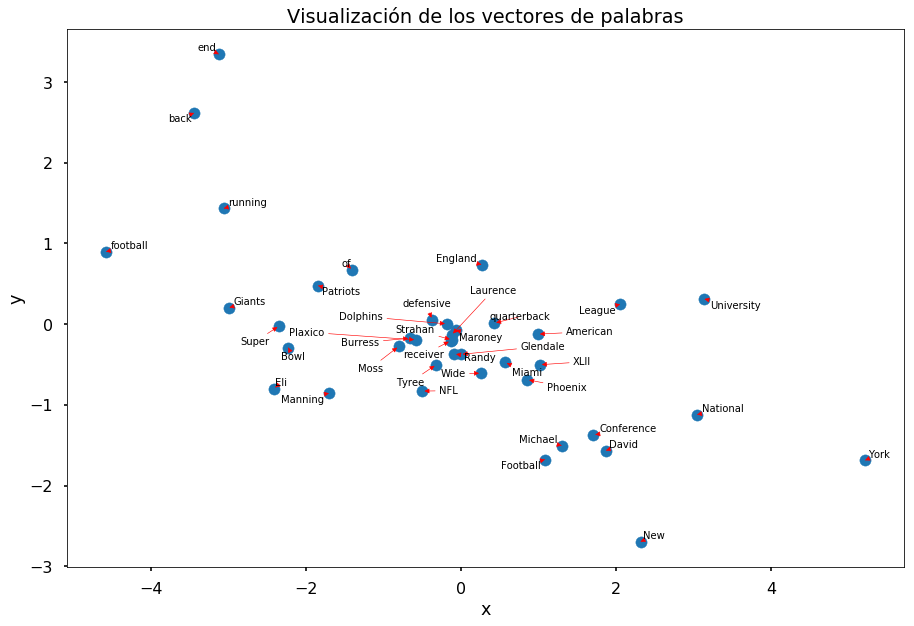

In [102]:
plt.style.use('seaborn-poster')

plt.title('Visualización de los vectores de palabras')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(result[:,0], result[:,1])

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(result[i,0], result[i,1], word))

adjust_text(texts, force_text=0.55, arrowprops=dict(arrowstyle="-|>", color='r', lw=0.6))

plt.tight_layout()
plt.show()

## Expansión de consultas

En el caso de wor2vec vamos a pasarle 

In [119]:
def get_expanded_query_w2v(model, q0, k=5):
    qe = []
    for word in q0.split(' '):
        expanded_words = [pair[0] for pair in model.most_similar(word)[:k]]
        expanded_words.append(word)
        qe.append(expanded_words)
    return qe
    
    
def get_expanded_query_glove(model, q0, k=5):
    qe = []
    for word in q0.split(' '):
        expanded_words = [pair[0] for pair in model.most_similar(word, number=k + 1)]
        expanded_words.append(word)
        qe.append(expanded_words)
    return qe


def get_elasticsearch_result(terms, client, index, num_results=10):
    """ Metodo que realiza una consulta a ElasticSearch sobre los
    términos 'terms' utilizando el cliente e index dados y devuelve
    uan lista con 'num_result' tweets tras aplicar la consulta.
    """
    queries = []
    for term in terms:
        queries.append(Q('match', text=' '.join(term)))
    q = Q('bool', should=queries)
    s = Search(using=client, index=index).query(q)
    result = [(res.text, res.meta.score) for res in s[:1000]]
    return result


def get_most_improved_tweet(original_tweets, expanded_tweets):
    pass

### Super Bowl
Vamos a empezar con la consulta 'Super Bowl'.

In [123]:
start_query = "Super Bowl"
num_expanded_words = 5
result_q0 = get_elasticsearch_result([['Super'], ['Bowl']], client, index)

qe_w2v = get_expanded_query_w2v(w2v_model, start_query)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

qe_glove = get_expanded_query_glove(glove_model, start_query)
result_glove = get_elasticsearch_result(qe_glove, client, index)

Resultados consulta original:

| resultado | relevante | razón |
|:-----:|:----:|:---:|
|{{result_q0[0][0]}}   |No  |  |
|{{result_q0[1][0]}}   |No | Aquí va el motivo por el que el tweet es relevante o no. |
|{{result_q0[2][0]}}   |No | Vale. |
|{{result_q0[3][0]}}   |No | |
|{{result_q0[4][0]}}   |No | Vale. |
|{{result_q0[5][0]}}   |No | |
|{{result_q0[6][0]}}   |No | Vale. |
|{{result_q0[7][0]}}   |Sí |  |
|{{result_q0[8][0]}}   |Sí | Vale. |
|{{result_q0[9][0]}}   |No | Repetido encima |

Resultados Word2Vec:

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No  |  |
|{{result_w2v[1][0]}}   |No | Aquí va el motivo por el que el tweet es relevante o no. |
|{{result_w2v[2][0]}}   |No | Vale. |
|{{result_w2v[3][0]}}   |No | |
|{{result_w2v[4][0]}}   |No | Vale. |
|{{result_w2v[5][0]}}   |No | |
|{{result_w2v[6][0]}}   |No | Vale. |
|{{result_w2v[7][0]}}   |Sí |  |
|Mayors bet food on Super Bowl(Reuters) http://tinyurl.com/3696qp  |Sí | Vale. |
|Mayors bet food on Super Bowl(Reuters) http://tinyurl.com/3696qp   |No | Repetido encima |

Resultados Glove:

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |No  | No lo sé |
|{{result_glove[1][0]}}   |Sí | Aquí va el motivo por el que el tweet es relevante o no. |
|{{result_glove[2][0]}}   |No | Vale. |
|{{result_glove[3][0]}}   |Sí | |
|{{result_glove[4][0]}}   |No | Vale. |
|{{result_glove[5][0]}}   |Sí | |
|{{result_glove[6][0]}}   |No | Vale. |
|{{result_glove[7][0]}}   |Sí |  |
|{{result_glove[8][0]}}   |No | Vale. |
|{{result_glove[9][0]}}   |No | Repetido encima |

### NFL
TODO

### Eli Manning
TODO

### 

## Comparativa del rendimiento de los modelos
En este apartado vamos a relizar una serie de mediciones sobre ambos modelos para ver 

In [29]:
def word2vec_benchmark(size=100, window=5, alpha=0.025, min_count=5, num_threads=1):
    word2vec.Word2Vec(sentences_generator, size=size, window=window,
                      alpha=alpha, min_count=min_count, workers=num_threads)
    

def glove_benchmark(window=5, size=100, alpha=0.05, epochs=10, num_threads=1):
    corpus_model = Corpus()
    corpus_model.fit(sentences_generator, window=window)
    glove = Glove(no_components=size, learning_rate=alpha)
    glove.fit(corpus_model.matrix, epochs=epochs,
              no_threads=1, verbose=False)

mem_usage_glove = memory_usage((glove_benchmark, (), {}))
mem_usage_w2v = memory_usage((word2vec_benchmark, (), {}))
time_glove = %timeit -n1 -r1 -o -q glove_benchmark()
time_w2v = %timeit -n1 -r1 -o -q word2vec_benchmark()

2min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


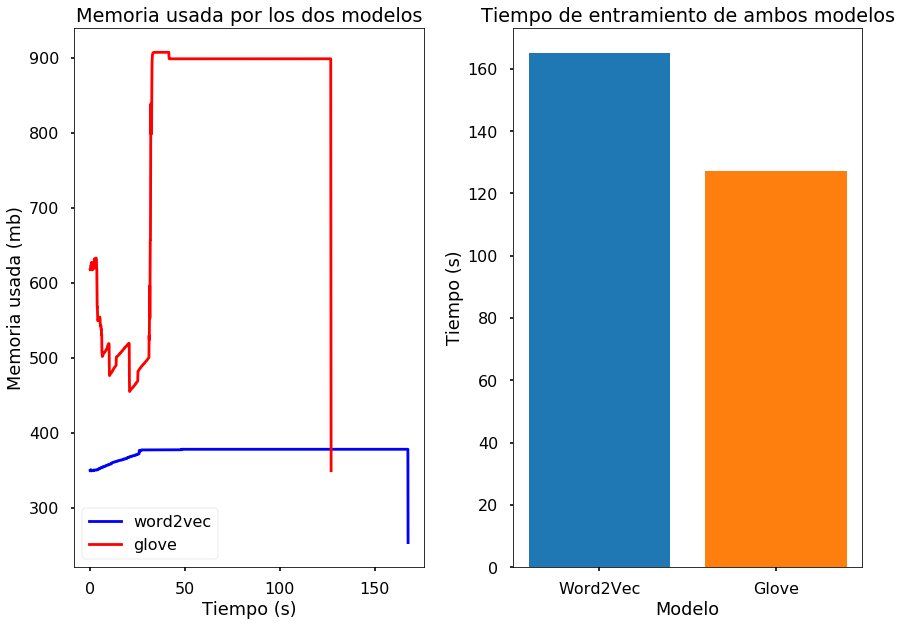

In [30]:
# plot de memoria usada por ambos modelos
plt.subplot(121)
plt.plot(np.arange(len(mem_usage_w2v)) * 0.1, mem_usage_w2v, 'b', label='word2vec')
plt.plot(np.arange(len(mem_usage_glove)) * 0.1, mem_usage_glove, 'r', label='glove')
plt.xlabel("Tiempo (s)")
plt.ylabel("Memoria usada (mb)")
plt.title("Memoria consumida por los dos modelos")
plt.legend()

# plot de tiempo que tardó cada modelo en entrenarse
plt.subplot(122)
xlabels = ["Word2Vec", "Glove"]
x = [0, 1]
y = [time_w2v.average, time_glove.average]
plt.bar([0], time_w2v.average)
plt.bar([1], time_glove.average)
plt.title("Tiempo de entramiento de ambos modelos")
plt.xlabel("Modelo empleado")
plt.ylabel("Tiempo (s)")
plt.xticks(x, xlabels)

plt.tight_layout()
plt.show()

NameError: name 'word2vec_benchmark' is not defined

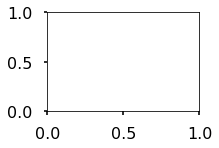

In [79]:
plt.subplot(221)
x = np.arange(0, 1, 0.1)
y_1 = []
y_2 = []
for i in x:
    time_w2v = %timeit -n1 -r1 -o -q word2vec_benchmark(alpha=i)
    y_1.append(time_w2v.average)
    time_glove = %timeit -n1 -r1 -o -q glove_benchmark(alpha=1)
    y_2.append(time_glove.average)

plt.plot(x, y_1, 'b', label='word2vec')
plt.plot(x, y_2, 'r', label='glove')
plt.ylabel("Tiempo (s)")
plt.xlabel("Ratio de aprendizaje")
plt.title("Evolución del tiempo en función de alfa")
plt.legend()


plt.subplot(222)
x = np.arange(50, 300, 20)
y_1 = []
y_2 = []
for i in x:
    time_w2v = %timeit -n1 -r1 -o -q word2vec_benchmark(size=i)
    y_1.append(time_w2v.average)
    time_glove = %timeit -n1 -r1 -o -q glove_benchmark(size=i)
    y_2.append(time_glove.average)

plt.plot(x, y_1, 'b', label='word2vec')
plt.plot(x, y_2, 'r', label='glove')
plt.ylabel("Tiempo (s)")
plt.xlabel("Nº de dimensiones de los vectores")
plt.title("Evolución del tiempo en función de las dimensiones de los vectores")
plt.legend()


plt.subplot(223)
x = [1, 2, 3, 4, 5]
y_1 = []
y_2 = []
for i in x:
    time_w2v = %timeit -n1 -r1 -o -q word2vec_benchmark(threads=i)
    y_1.append(time_w2v.average)
    time_glove = %timeit -n1 -r1 -o -q glove_benchmark(threads=i)
    y_2.append(time_glove.average)

plt.plot(x, y_1, 'b', label='word2vec')
plt.plot(x, y_2, 'r', label='glove')
plt.ylabel("Tiempo (s)")
plt.xlabel("Nº de threads usados")
plt.title("Evolución del tiempo en función del número de threads")
plt.legend()


plt.subplot(224)
x = np.arange(2, 20, 1)
y_1 = []
y_2 = []
for i in x:
    time_w2v = %timeit -n1 -r1 -o -q word2vec_benchmark(window=i)
    y_1.append(time_w2v.average)
    time_glove = %timeit -n1 -r1 -o -q glove_benchmark(window=i)
    y_2.append(time_glove.average)

plt.plot(x, y_1, 'b', label='word2vec')
plt.plot(x, y_2, 'r', label='glove')
plt.ylabel("Tiempo (s)")
plt.xlabel("Tamaño del contexto")
plt.title("Evolución del tiempo en función del tamaño del contexto")
plt.legend()


plt.tight_layout()
plt.show()